In [1]:
import string
import re
import nltk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
lemmatizer = WordNetLemmatizer()

def process_tweet(tweet):

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)

    tokenizer = TweetTokenizer(preserve_case = False, reduce_len = True, strip_handles = True)
    tokens = tokenizer.tokenize(tweet)
    tokens_tags = nltk.pos_tag(tokens, lang = 'eng')

    tweet_clean = []

    for token, tag in tokens_tags:
        if (token not in stopwords_english and
            token not in string.punctuation):

            stem_token = lemmatizer.lemmatize(word = token, pos = pos_tag_convert(tag))
            tweet_clean.append(stem_token)

    return tweet_clean

In [3]:
def pos_tag_convert(nltk_tag: str):

    if nltk_tag.startswith('J'):
        return wordnet.ADJ

    elif nltk_tag.startswith('V'):
        return wordnet.VERB

    elif nltk_tag.startswith('N'):
        return wordnet.NOUN

    elif nltk_tag.startswith('R'):
        return wordnet.ADV

    else:
        return wordnet.NOUN

In [4]:
def load_tweets():

    all_pos_tweets = twitter_samples.strings('positive_tweets.json')
    all_neg_tweets = twitter_samples.strings('negative_tweets.json')

    return all_pos_tweets, all_neg_tweets

In [5]:
all_positive_tweets, all_negative_tweets = load_tweets()

In [6]:
all_positive_tweets_processed = list(map(process_tweet , all_positive_tweets))
all_negative_tweets_processed = list(map(process_tweet , all_negative_tweets))

In [7]:
train_positive = all_positive_tweets_processed[:4000]
val_positive = all_positive_tweets_processed[4000:]

train_negative = all_negative_tweets_processed[:4000]
val_negative = all_negative_tweets_processed[4000:]

train_x = train_positive + train_negative
val_x = val_positive + val_negative

# for positive tweets append 1 for negative append 0
train_y = [[1] for _ in train_positive] + [[0] for _ in train_negative]
val_y  = [[1] for _ in val_positive] + [[0] for _ in val_negative]

In [8]:
def build_vocabulary(training_corpus):

    vocab = {'' : 0 , '[UNK]': 1}
    # start index from 2 because we are already have 2 tokens in vocab
    current_idx = 2

    for sentence in training_corpus:
        for word in sentence:

            if word not in vocab:
                vocab[word] = current_idx
                current_idx += 1

    return vocab

In [9]:
vocab = build_vocabulary(train_x)

In [10]:
print(f"vocab size: {len(vocab)}\n")
print("first 5 elements in vocab")
print({k : v for k, v in list(vocab.items())[:5]})

vocab size: 9544

first 5 elements in vocab
{'': 0, '[UNK]': 1, 'followfriday': 2, 'top': 3, 'engage': 4}


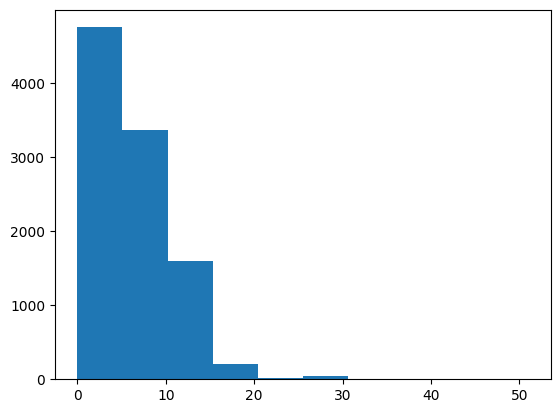

In [11]:
# visualize the sequence length
plt.hist([len(t) for t in train_x + val_x]);

In [12]:
def max_length(training_x, validation_x):

    max_len = max([len(tweet) for tweet in training_x + validation_x])

    return max_len

In [13]:
max_len = max_length(train_x, val_x)
print(f"max input length: {max_len}")

max input length: 51


In [14]:
def padded_sequence(tweet, vocab, max_len, unk_token = '[UNK]'):

    # if the word exists in vocab return its idx, if not return UNK idx
    tweet_idxs = list(map(lambda word : vocab.get(word, vocab[unk_token]), tweet))

    # get the padding
    pad = [vocab[unk_token]] * (max_len - len(tweet_idxs))

    # pad the sequence to the max length
    padded_tweet = tweet_idxs + pad

    return padded_tweet

In [15]:
train_x_padded = list(map(lambda x : padded_sequence(x,vocab, max_len) , train_x))
val_x_padded = list(map(lambda x : padded_sequence(x,vocab, max_len) , val_x))

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

In [17]:
# column vector
v = np.array([[12],[13],[-2],[-0.002],[2.5],[0]])

print("try sigmoid function")
print(sigmoid(v),"\n")

print("try relu function")
print(relu(v))

try sigmoid function
[[0.99999386]
 [0.99999774]
 [0.11920292]
 [0.4995    ]
 [0.92414182]
 [0.5       ]] 

try relu function
[[12. ]
 [13. ]
 [ 0. ]
 [ 0. ]
 [ 2.5]
 [ 0. ]]


In [18]:
class Dense():

    def __init__(self, n_units, input_size, activation, std = 1, random_seed = 42):

        self.n_units = n_units
        self.input_size = input_size
        self.activation = activation

        self.random_generator = np.random.default_rng(seed = random_seed)
        self.weights = self.random_generator.normal(scale = std, size = (n_units, input_size[-1]))

    def forward(self, x):

        dense = np.dot(self.weights, x)
        dense = self.activation(dense)

        return dense

    def __call__(self, x):
        return self.forward(x)

In [19]:
n_units = 10
input = train_x_padded[0]
activation = sigmoid
dense_layer = Dense(n_units, np.array(input).shape, activation)

In [20]:
print(f"wights shape: {dense_layer.weights.shape}")

wights shape: (10, 51)


In [21]:
print(f"output shape: {dense_layer(input).shape}")

output shape: (10,)


In [22]:
def create_model(vocab_size, embed_dim, activation):

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_dim),
        #merges each sequence to be represented in one vector
        # ex, input seq (2, 4, 3), the output will be (2, 3)
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation)
    ])

    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

    return model

In [23]:
vocab_size = len(vocab)
embed_dim = 16
activation = 'sigmoid'
model = create_model(vocab_size, embed_dim, activation)

In [24]:
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

In [25]:
model.fit(x = train_x_prepared,
          y = train_y_prepared,
          validation_data = (val_x_prepared, val_y_prepared),
          epochs=20)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5652 - loss: 0.6842 - val_accuracy: 0.8615 - val_loss: 0.6233
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.5794 - val_accuracy: 0.9955 - val_loss: 0.4483
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.3998 - val_accuracy: 0.9945 - val_loss: 0.2880
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.2550 - val_accuracy: 0.9965 - val_loss: 0.1883
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.1650 - val_accuracy: 0.9965 - val_loss: 0.1299
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9947 - loss: 0.1156 - val_accuracy: 0.9940 - val_loss: 0.0960
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0820 - val_accuracy: 0.9950 - val_loss: 0.0701
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9941 - loss: 0.0654 - val_accuracy: 0.

In [26]:
def get_prediction_from_tweet(tweet: str, model: model, vocab, max_len):

    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    pred = model.predict(tweet)

    return pred

In [27]:
unseen_tweet = '@DLAI @NLP_team_dlai OMG!!! what bad a good daaay, wow, wow. This AsSiGnMeNt was gr8.'

get_prediction_from_tweet(unseen_tweet, model, vocab,max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


array([[0.6721688]], dtype=float32)

In [28]:
embed_weights = model.layers[0].weights[0]

In [29]:
embed_weights

<KerasVariable shape=(9544, 16), dtype=float32, path=sequential/embedding/embeddings>

In [30]:
pca = PCA(n_components = 2)
embeddings_2D = pca.fit_transform(embed_weights)

In [31]:
embeddings_2D

array([[-0.02229602,  0.01172211],
       [-0.04365615,  0.01351624],
       [-1.97163742, -0.0503504 ],
       ...,
       [ 0.45126094,  0.03200919],
       [ 0.72559031,  0.01573907],
       [ 0.46540534, -0.06063522]])

In [32]:
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst']
pos_words = ['best', 'good', 'nice', 'love', 'better']

neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

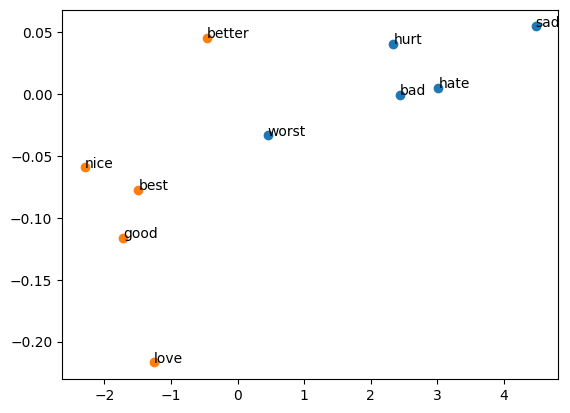

In [33]:
plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1])
plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1])

for i in range(len(neg_n)):
    plt.annotate(neg_words[i], (embeddings_2D[neg_n][i,0],embeddings_2D[neg_n][i,1]))

for i in range(len(pos_n)):
    plt.annotate(pos_words[i],(embeddings_2D[pos_n][i,0],embeddings_2D[pos_n][i,1]))